## Importing necessary libraries and setting up preprocessing



In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from warnings import filterwarnings

# Suppress warnings
filterwarnings('ignore')

# Define image size
imgSize = 64

# Define the transformations for the images
transformer = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to data
path = '/kaggle/input/melanoma/train'
valPath = '/kaggle/input/melanoma/test'

# Load datasets
trainData = datasets.ImageFolder(root=path, transform=transformer)
valData = datasets.ImageFolder(root=valPath, transform=transformer)

# Define batch size
batchSize = 16

# Data loaders
trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True, num_workers=4)
valLoader = DataLoader(valData, batch_size=batchSize, shuffle=False, num_workers=4)


## Hyperparameter optimization with Optuna





In [15]:
# Define the search space for Optuna
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes for binary classification
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, threshold=0.01, factor=0.1, patience=3, min_lr=1e-5, verbose=True)
    
    patience = 5
    minDelta = 0.01
    currentPatience = 0
    bestRecall = 0.0
    
    scaler = GradScaler()
    epochs = 20
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        runningLoss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            runningLoss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        trainLoss = runningLoss / len(trainLoader)
        accuracy = correct / total
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in valLoader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = val_correct / val_total
        
        if val_accuracy > bestRecall:
            bestRecall = val_accuracy
            currentPatience = 0
        else:
            currentPatience += 1
            if currentPatience >= patience:
                break
        
        scheduler.step(val_accuracy)
    
    return -bestRecall  # Minimize negative recall to maximize recall

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)



[I 2024-04-09 14:34:41,757] A new study created in memory with name: no-name-be0f8e21-2a07-43d0-befb-aa09f7c0fa3c
[I 2024-04-09 14:38:03,841] Trial 0 finished with value: -0.934 and parameters: {'lr': 0.0002885768804824497, 'weight_decay': 0.0009152947894816398}. Best is trial 0 with value: -0.934.


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00007: reducing learning rate of group 0 to 5.9282e-04.
Epoch 00011: reducing learning rate of group 0 to 5.9282e-05.
Epoch 00015: reducing learning rate of group 0 to 1.0000e-05.


[I 2024-04-09 14:56:38,207] Trial 2 finished with value: -0.879 and parameters: {'lr': 0.005928170812279339, 'weight_decay': 0.0008438666886974421}. Best is trial 1 with value: -0.9605.


Epoch 00005: reducing learning rate of group 0 to 9.7777e-04.
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


[I 2024-04-09 15:16:12,256] Trial 4 finished with value: -0.962 and parameters: {'lr': 8.352218209613642e-05, 'weight_decay': 0.0001737253003586234}. Best is trial 4 with value: -0.962.


Best Hyperparameters: {'lr': 8.352218209613642e-05, 'weight_decay': 0.0001737253003586234}


## Training the model with best hyperparameters


In [16]:
# Training with best hyperparameters
best_lr = best_params['lr']
best_weight_decay = best_params['weight_decay']

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes for binary classification
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
scheduler = ReduceLROnPlateau(optimizer, threshold=0.01, factor=0.1, patience=3, min_lr=1e-5, verbose=True)

scaler = GradScaler()

trainLosses = []
valRecalls = []

epochs = 10

for epoch in range(epochs):
    model.train()
    runningLoss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        runningLoss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    trainLoss = runningLoss / len(trainLoader)
    accuracy = correct / total
    
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = val_correct / val_total
    
    scheduler.step(val_accuracy)


Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


## Evaluation:




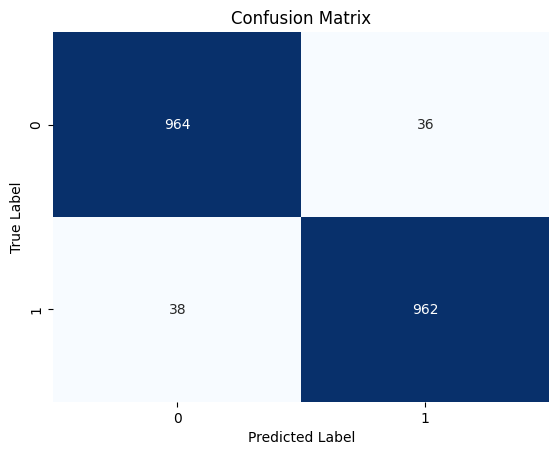

Test Accuracy: 0.9630
Test Recall: 0.9620


In [17]:
# Plot confusion matrix
model.eval()
allLabels = []
allPredictions = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        allLabels.extend(labels.cpu().numpy())
        allPredictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(allLabels, allPredictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Testing phase
testLoader = valLoader  # Use the validation loader for testing

model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels in testLoader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

# Compute test recall
test_recall = recall_score(allLabels, allPredictions)
print(f"Test Recall: {test_recall:.4f}")
